## **Data**

In [2]:
from data.huggan_smithsonian_butterflies_subset import  DataModule

data_module = DataModule()
data_module.prepare_data()
dl = data_module.train_dataloader()

sample = next(iter(dl))
print(sample.min(), sample.max())
sample.shape

Repo card metadata block was not found. Setting CardData to empty.


tensor(-1.) tensor(1.)


torch.Size([8, 3, 128, 128])

## **Scheduler**

torch.Size([8]) 1000


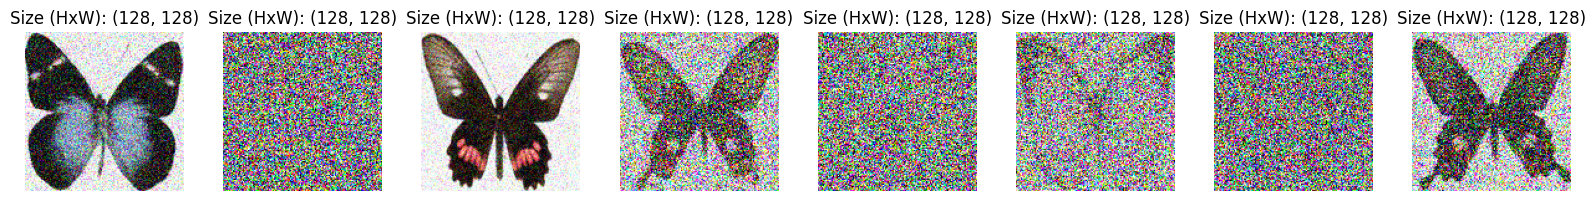

In [6]:
from diffusers import DDPMScheduler
import torch
def get_scheduler():
    return  DDPMScheduler(
        num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
    )
scheduler = get_scheduler()
timesteps = torch.randint(0,scheduler.num_train_timesteps,[sample.size(0)])
print(timesteps.shape, get_scheduler().num_train_timesteps)
noises = torch.randn_like(sample)

# The timesteps is the index timestep for each image, so that image only have one version of noisy, not that each image will have len(timesteps)
#  versions of noisy. It  must be 1-D Tensor, `assert len(timesteps.shape) == 1` in `TimeSteps.forward`.
noised_x = scheduler.add_noise(sample, noises, timesteps)
data_module.show((noised_x*0.5+0.5).clamp(0,1).permute(0,2,3,1).numpy(),img_per_row=int(len(noised_x)) )

In [8]:
type(scheduler.config)

diffusers.configuration_utils.FrozenDict

## **Unet**

In [21]:
from diffusers import UNet2DModel

def get_model():
    return UNet2DModel(
        # Image shape i/o
        sample_size=[128, 128],
        in_channels=3,
        out_channels=3,

        # Unet blocks
        down_block_types=["DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"],
        mid_block_type = "UNetMidBlock2D",
        up_block_types=["UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"],

        # The number of channels per block.
        # Must be equal to length of `down_block_types` and `up_block_types` (All three must have the same length).
        block_out_channels=[128, 128, 256, 256, 512, 512],

        # Misc
        act_fn="silu",
        time_embedding_type= "positional",

        # Scale [0,1] to [-1,1] or not by apply `sample = 2 * sample - 1.0` in forward method.
        center_input_sample=False,

        # for i in range(layers_per_block):
        #   in_channels = in_channels if i == 0 else out_channels
        #   resnets.append(ResnetBlock2D( ...
        layers_per_block = 2,
)
with torch.inference_mode():
    output = get_model()(noised_x, timestep = timesteps).sample
    print(noised_x.shape)
    print(output.shape)

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


## **Training**
1. Load batch of images.
2. Add noise. Goal is to train a robust model to denoise no matter how much noise is in the input. So we add noise with random step for each image.
3. Forward with noisy images.
4. Calculate loss with MSE between **predicted and actual noise**.
5. Backward and train.

### Model